In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network, Inf_network_simple, Gen_network_simple
from target import NN_bernoulli, GMM_target, NN_Gaussian
from utils import plot_digit_samples, get_samples
from args import get_args

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
    torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

args.data = "mnist"
args.z_dim = 64
args.data_distrib = GMM_target(args, args.device)

In [5]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.learnable_reverse:
    reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    
if args.fix_transition_params:
    for p in transitions.parameters():
        transitions.requires_grad_(False)

if args.separate_params:
    params_decoder = list(target.parameters())
    params_inference = list(encoder.parameters()) + list(transitions.parameters()) + list(reverse_params)
    optimizer_inference = torch.optim.Adam(params=params_inference, lr=args.learning_rate_inference)
    optimizer = torch.optim.Adam(params=params_decoder, lr=args.learning_rate)
else:
    params = list(encoder.parameters()) + list(target.parameters()) + list(transitions.parameters()) + list(reverse_params)
    optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)
    
optimizer_vanilla = torch.optim.Adam(params=list(encoder.parameters()) + list(target.parameters()), lr= args.learning_rate_vanilla)

In [6]:
if args.vanilla_vae_epoches > 0:
    batch_size = args.train_batch_size
    args.train_batch_size = 100 # just for Vanilla VAE training
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

In [8]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new).sum(1)
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo

In [9]:
def validate_vae(args, encoder, target, transitions, dataset):
    elbo_list = []
    for batch_num, batch_val in enumerate(dataset.next_val_batch()):
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None
        mu, sigma = encoder(batch_val)
        
        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u
        
        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]
        p = p_old
        
        for k in range(args.K):
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_val,
                                                    p_old=p, k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_val,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        elbo_current, _ = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_val, sum_log_alpha=sum_log_alpha,
                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
        
        elbo_list.append(elbo_current.cpu().detach().numpy())
    mean_val_elbo = np.mean(elbo_list)
    return mean_val_elbo


  0%|          | 0/1000 [00:00<?, ?it/s]

Current epoch: 1 	 Current ELBO: -114.8134536743164
Saved samples to ./pics/mnist_epoch_0_K_3_N_3_amortize_False.png


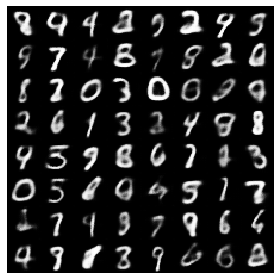


  0%|          | 1/1000 [00:06<1:51:54,  6.72s/it]

Current epoch: 2 	 Current ELBO: -112.6064453125
Saved samples to ./pics/mnist_epoch_1_K_3_N_3_amortize_False.png


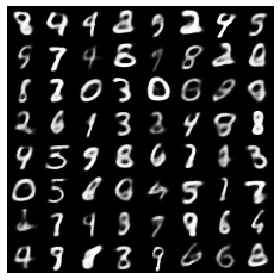


  0%|          | 2/1000 [00:13<1:51:26,  6.70s/it]

Current epoch: 3 	 Current ELBO: -110.31681823730469
Saved samples to ./pics/mnist_epoch_2_K_3_N_3_amortize_False.png


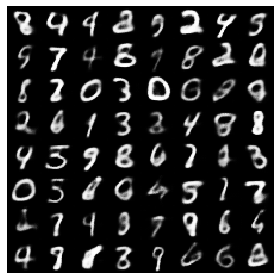


  0%|          | 3/1000 [00:20<1:51:04,  6.68s/it]

Current epoch: 4 	 Current ELBO: -109.89087677001953
Saved samples to ./pics/mnist_epoch_3_K_3_N_3_amortize_False.png


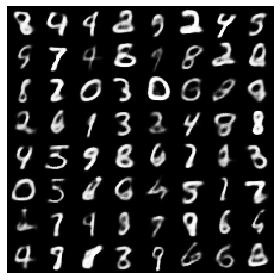


  0%|          | 4/1000 [00:26<1:50:46,  6.67s/it]

Current epoch: 5 	 Current ELBO: -107.70747375488281
Saved samples to ./pics/mnist_epoch_4_K_3_N_3_amortize_False.png


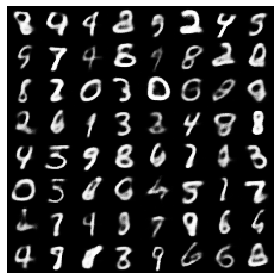


  0%|          | 5/1000 [00:33<1:50:41,  6.67s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.4680000222288072 and for +1: 0.5320000252686441
On batch number 1/118 and on k = 2 we have for  0: 0.5040000239387155 and for +1: 0.49600002355873585
On batch number 1/118 and on k = 3 we have for  0: 0.49400002346374094 and for +1: 0.5060000240337104
> <ipython-input-11-de8ad88f9678>(82)<module>()
-> current_elbo_val = validate_vae(args=args, encoder=encoder, target=target, transitions=transitions, dataset=dataset)


(Pdb)  s


--Call--
> <ipython-input-9-5782fe9e4e2b>(1)validate_vae()
-> def validate_vae(args, encoder, target, transitions, dataset):


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(2)validate_vae()
-> elbo_list = []


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(3)validate_vae()
-> for batch_num, batch_val in enumerate(dataset.next_val_batch()):


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(4)validate_vae()
-> if args.learnable_reverse:


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(5)validate_vae()
-> all_directions = torch.tensor([], device=args.device)


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(8)validate_vae()
-> mu, sigma = encoder(batch_val)


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(10)validate_vae()
-> sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(11)validate_vae()
-> sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(12)validate_vae()
-> sum_log_sigma = torch.sum(torch.log(sigma), 1)


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(14)validate_vae()
-> u = args.std_normal.sample(mu.shape)


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(15)validate_vae()
-> z = mu + sigma * u


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(17)validate_vae()
-> p_old = args.std_normal.sample(z.shape)


(Pdb)  print(z.shape)


torch.Size([100, 64])


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(18)validate_vae()
-> cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]


(Pdb)  print(p_old.shape)


torch.Size([100, 64])


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(19)validate_vae()
-> p = p_old


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(21)validate_vae()
-> for k in range(args.K):


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(22)validate_vae()
-> if args.amortize:


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(26)validate_vae()
-> z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_val,


(Pdb)  s


--Call--
> /home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/nn/modules/container.py(142)__getitem__()
-> @_copy_to_script_wrapper


(Pdb)  s


> /home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/nn/modules/container.py(144)__getitem__()
-> if isinstance(idx, slice):


(Pdb)  s


> /home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/nn/modules/container.py(147)__getitem__()
-> return self._modules[self._get_abs_string_index(idx)]


(Pdb)  s


--Call--
> /home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/nn/modules/container.py(133)_get_abs_string_index()
-> def _get_abs_string_index(self, idx):


(Pdb)  s


> /home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/nn/modules/container.py(135)_get_abs_string_index()
-> idx = operator.index(idx)


(Pdb)  n


> /home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/nn/modules/container.py(136)_get_abs_string_index()
-> if not (-len(self) <= idx < len(self)):


(Pdb)  n


> /home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/nn/modules/container.py(138)_get_abs_string_index()
-> if idx < 0:


(Pdb)  n


> /home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/nn/modules/container.py(140)_get_abs_string_index()
-> return str(idx)


(Pdb)  n


--Return--
> /home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/nn/modules/container.py(140)_get_abs_string_index()->'0'
-> return str(idx)


(Pdb)  n


--Return--
> /home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/nn/modules/container.py(147)__getitem__()->HMC_our()
-> return self._modules[self._get_abs_string_index(idx)]


(Pdb)  n


> <ipython-input-9-5782fe9e4e2b>(27)validate_vae()
-> p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions


(Pdb)  s


--Call--
> /home/nkotelevskii/github/hmc_ouralg/kernels.py(79)make_transition()
-> def make_transition(self, q_old, p_old, target_distr, k=None, x=None):


(Pdb)  n


> /home/nkotelevskii/github/hmc_ouralg/kernels.py(97)make_transition()
-> alpha = torch.sigmoid(self.alpha_logit)


(Pdb)  n


> /home/nkotelevskii/github/hmc_ouralg/kernels.py(98)make_transition()
-> p_ref = p_old * alpha + torch.sqrt(1. - alpha ** 2) * k


(Pdb)  n


> /home/nkotelevskii/github/hmc_ouralg/kernels.py(99)make_transition()
-> log_jac = p_old.shape[1] * torch.log(alpha) * torch.ones(q_old.shape[0], device=self.device)


(Pdb)  n


> /home/nkotelevskii/github/hmc_ouralg/kernels.py(101)make_transition()
-> q_upd, p_upd = self._forward_step(q_old=q_old, p_old=p_ref, k=k, target=target_distr, x=x)


(Pdb)  s


--Call--
> /home/nkotelevskii/github/hmc_ouralg/kernels.py(24)_forward_step()
-> def _forward_step(self, q_old, x=None, k=None, target=None, p_old=None):


(Pdb)  n


> /home/nkotelevskii/github/hmc_ouralg/kernels.py(40)_forward_step()
-> gamma = torch.exp(self.gamma)


(Pdb)  n


> /home/nkotelevskii/github/hmc_ouralg/kernels.py(41)_forward_step()
-> p_flipped = -p_old


(Pdb)  n


> /home/nkotelevskii/github/hmc_ouralg/kernels.py(43)_forward_step()
-> p_ = p_flipped + gamma / 2. * self.get_grad(q=q_old, target=target, x=x)  # NOTE that we are using log-density, not energy!


(Pdb)  s


--Call--
> /home/nkotelevskii/github/hmc_ouralg/kernels.py(130)get_grad()
-> def get_grad(self, q, target, x=None):


(Pdb)  n


> /home/nkotelevskii/github/hmc_ouralg/kernels.py(131)get_grad()
-> q_init = q.detach().requires_grad_(True)


(Pdb)  n


> /home/nkotelevskii/github/hmc_ouralg/kernels.py(132)get_grad()
-> if self.naf:


(Pdb)  q_init.requires_grad


True


(Pdb)  n


> /home/nkotelevskii/github/hmc_ouralg/kernels.py(142)get_grad()
-> grad = torch.autograd.grad(target.get_logdensity(x=x, z=q_init).sum(), q_init)[


(Pdb)  target.get_logdensity(x=x, z=q_init).sum()


tensor(-19163.2969, device='cuda:0')


(Pdb)  target.get_logdensity(x=x, z=q_init)


tensor([-195.1643, -196.1224, -179.0189, -181.4016, -187.9224, -236.5076,
        -210.4203, -184.0355, -188.4455, -162.5962, -180.6078, -185.7012,
        -193.4007, -308.0212, -193.2895, -177.9792, -240.4525, -201.1537,
        -136.5717, -217.7968, -210.5856, -175.1805, -214.8801, -196.4617,
        -175.5843, -177.4638, -193.3525, -172.0391, -247.1492, -216.1709,
        -201.3328, -216.5621, -181.6548, -180.9037, -162.4623, -239.7399,
        -180.5782, -171.9159, -126.7769, -168.7485, -181.9032, -234.4838,
        -153.8051, -222.8849, -211.0860, -193.9111, -207.9582, -193.6798,
        -151.7417, -213.8811, -211.1366, -176.0132, -181.6501, -213.1758,
        -194.0582, -151.1091, -185.4805, -178.4859, -219.2096, -231.5498,
        -169.0684, -210.6870, -196.4480, -201.6904, -203.2500, -185.8103,
        -202.4628, -190.3752, -174.8857, -207.8817, -235.4636, -166.2133,
        -179.0968, -163.6343, -194.2875, -187.1567, -206.5325, -174.6509,
        -221.0995, -207.3988, -168.723

(Pdb)  q


BdbQuit: 

In [11]:
print_info_ = 1
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)

best_elbo = -float("inf")

current_tolerance = 0
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        target.decoder.train()
        plt.close()        

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        if ep < args.vanilla_vae_epoches:
            log_p = target.get_logdensity(z=z, x=batch_train)
            log_m = args.std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo_full = torch.mean(log_p - log_m)
            (-elbo_full).backward()
            optimizer_vanilla.step()
            optimizer_vanilla.zero_grad()
            if b_num == (args.train_batch_size - 1):
                args.train_batch_size = batch_size
                dataset = Dataset(args, device=args.device)
        else:
            p_old = args.std_normal.sample(z.shape)
            cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]

            sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
            sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
            p = p_old
            if args.learnable_reverse:
                all_directions = torch.tensor([], device=args.device)
            else:
                all_directions = None
            for k in range(args.K):
                # sample alpha - transition probabilities 
                if args.amortize:
                    pdb.set_trace()
                    z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                        p_old=p, k=cond_vectors[k], target_distr=target)
                else:
                    z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
                if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                    print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                            dataset.train.shape[0] // args['train_batch_size'],
                                                                               k + 1,
                                                        (directions==0.).to(float).mean(),
                                                                        (directions==1.).to(float).mean()))
                    if args.amortize:
                        print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                        print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
                if args.learnable_reverse:
                    all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
                # Accumulate alphas
                sum_log_alpha = sum_log_alpha + current_log_alphas
                sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian

            elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                                sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
        #     pdb.set_trace()
            (-grad_elbo).backward()
            if args.clip_norm:
                torch.nn.utils.clip_grad_norm_(itertools.chain(*params), args.clip_value)
                
            if args.separate_params: # if we separate params of inference part and generation part
                optimizer_inference.step() # we always perform step for inference part
                if (ep - args.vanilla_vae_epoches) % args.train_only_inference_period > args.train_only_inference_cutoff: # but sometimes for gen
                    optimizer.step()
                optimizer.zero_grad()
                optimizer_inference.zero_grad()
            else:
                optimizer.step()
                optimizer.zero_grad()
                
            # validation
            target.decoder.eval()
            pdb.set_trace()
            current_elbo_val = validate_vae(args=args, encoder=encoder, target=target, transitions=transitions, dataset=dataset)
            if (current_elbo_val != current_elbo_val).sum():
                print('NAN appeared!')
                raise ValueError
            if current_elbo_val > best_elbo:
                current_tolerance = 0
                best_elbo = current_elbo_val
                if not os.path.exists('./models/{}/'.format(args.data)):
                    os.makedirs('./models/{}/'.format(args.data))
                torch.save(encoder,
                    './models/{}/best_encoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}.pt'.format(args.data,
                                            args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse))
                torch.save(decoder,
                    './models/{}/best_decoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}.pt'.format(args.data,
                                            args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse))
                torch.save(transitions,
                    './models/{}/best_transitions_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}.pt'.format(args.data,
                                            args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse))
            else:
                current_tolerance += 1
                if current_tolerance >= args.early_stopping_tolerance:
                    print("Early stopping on epoch {} (effectively trained for {} epoches)".format(ep,
                                                      ep - args.early_stopping_tolerance))
                    break           
            print('Current elbo validation:', current_elbo_val)
                
    if ep % print_info_ == 0:
        target.decoder.eval()
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo_full.detach().mean().item())
        plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
print('a')

In [ ]:
elbo_full.mean()

In [ ]:
print(args.learnable_reverse)

## Vanilla VAE

In [ ]:
dataset = Dataset(args, device=args.device)

In [ ]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

params = [encoder.parameters(), target.parameters()]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=args.learning_rate)

In [ ]:
print_info_ = 10

# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        plt.close()
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        
        mu_dec, sigma_dec = target.decoder(z)
        if args.data == 'toy_data':
            log_numenator = torch.distributions.Normal(loc=mu_dec, scale=sigma_dec).log_prob(batch_train).sum(1) + args.std_normal.log_prob(z).sum(1)
        else:
            log_numenator = torch.distributions.Bernoulli(logits=mu_dec).log_prob(batch_train).sum([1, 2, 3]) + args.std_normal.log_prob(z).sum(1)
        log_denumenator = -torch.sum(torch.log(sigma), 1) + args.std_normal.log_prob(u).sum(1)
        elbo = torch.mean(log_numenator - log_denumenator)
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    if ep % print_info_ == 0:
        if args.data == 'toy_data':
            print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo.detach().mean().item())
            print('Mean abs mu0:', torch.mean(torch.abs(mu_dec[:, 0])).cpu().detach().numpy())
            print('Mean sigma', torch.mean(sigma).cpu().detach().numpy())
            print('Max sigma', torch.max(sigma).cpu().detach().numpy())
            print('Min sigma', torch.min(sigma).cpu().detach().numpy())
            plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1], label='Data')
            plt.scatter(mu_dec.cpu().detach().numpy()[:, 0], mu_dec.cpu().detach().numpy()[:, 1], label='Reconstructed')
            plt.legend()
            plt.show()
        else:
            plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [10]:
target.decoder.linear1.bias

Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,